In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
import math
from collections import Counter

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from scipy.stats import spearmanr

# **Dataset import**

In [ ]:
# Import the data relative to the sentences positions and statistics 
# (sentence_statistic.csv).
print('\nImport sentence_statistic.csv\n')
upload = files.upload()

# Import the data relative to the statistic about the sentences dependency trees 
# (sentence_dependency_tree_stat.csv).
print('\nImport sentence_dependency_tree_stat.csv\n')
upload = files.upload()

# Import the text file previously produced containing the prediction scores
# of the subjectivity of each sentence in the dataset (sub_obj.txt).
print('\nImport sub_obj.txt\n')
upload = files.upload()

# Import the dataframe previously produced containing the BOW on the dataset of 
# the n-grams indicated in the appendix of the guidelines of the Stab and Gurevych 
# dataset (2017 version) as indicative of an argumentative sections (claim or premise).
#(file: essay_BOW_appendix_words.cvs)
print('\nImport essay_BOW_appendix_words.cvs\n')
upload = files.upload()


Import sentence_statistic.csv



Saving sentence_statistic.csv to sentence_statistic.csv

Import sentence_dependency_tree_stat.csv



Saving sentence_dependency_tree_stat.csv to sentence_dependency_tree_stat.csv

Import sub_obj.txt



Saving subj_obj.txt to subj_obj.txt

Import essay_BOW_appendix_words.cvs



Saving essay_BOW_appendix_words.csv to essay_BOW_appendix_words.csv


In [ ]:
# Import the Stab and Gurevych dataset (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

# **Create the ann Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
Essay_ann_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(Essay_ann_dataset.index)):
  Essay_ann_dataset['span'][i]=Essay_ann_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Essay_ann_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T2,0,T2,MajorClaim,"(2154, 2231)",a more cooperative attitudes towards life is m...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."


# **IOB and word list**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[sorted(list(Essay_ann_dataset.loc[Essay_ann_dataset['doc_id'] == i,['span','type']].values), key=lambda element: (element[0][0]) ) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay and the corresponding labels 
# ( argumentative section, premise or claim indicated through IOB).

Y_IOB=[]
X_essay_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  # Set boolean value next_token_is_argumentative to false.
  # (first section of each essay is never argumentative, it's the one containing the title).
  next_token_is_argumentative=False

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

    if next_token_is_argumentative:
      if sorted_span[i][next_type][1]=='Premise':
        IOB+=['B-P']
        for token in range(len(seq)-1):
          IOB+=['I-P']
      else:
        IOB+=['B-C']
        for token in range(len(seq)-1):
          IOB+=['I-C']
      next_type += 1     
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB.append(IOB)
  X_essay_word_list.append(essay_word_list)

In [ ]:
for i in range(80,120):
  print(X_essay_word_list[0][i]+" - "+Y_IOB[0][i])

i - O
firmly - O
believe - O
that - O
we - B-C
should - I-C
attach - I-C
more - I-C
importance - I-C
to - I-C
cooperation - I-C
during - I-C
primary - I-C
education - I-C
. - O
first - O
of - O
all - O
, - O
through - B-C
cooperation - I-C
, - I-C
children - I-C
can - I-C
learn - I-C
about - I-C
interpersonal - I-C
skills - I-C
which - I-C
are - I-C
significant - I-C
in - I-C
the - I-C
future - I-C
life - I-C
of - I-C
all - I-C
students - I-C
. - O
what - B-P


# **Find out sentences which contain argumentative section**

In [ ]:
# Get the list of all the sentences and the fact that they contain 
# an argumentative section, a premise or a claim or not.

sentence_list=[]
sentences_argumentative_map=[]

# Argumentative sentences contains or a premise or a claim (not both).
# The following list of boolean will contain value True in case of a claim and
# value False in case of a premise.
argumentative_sentences_claim_presence_map=[]
# List of sentences which are agumentative but contains either a claim or 
# a premise not both.
argumentative_sentences_not_both_map=[]

# List containing the id of the essay for each sentence in the corpus.
sentence_essay_id_list=[]

for essay_id in range(len(X_essay_word_list)):
  sentence=""
  argumentative=False
  claim=False
  premise=False

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]
    bio_of_word=Y_IOB[essay_id][word_id]

    if not (bio_of_word=='O'):
      argumentative=True
      if (bio_of_word=='I-C') or (bio_of_word=='B-C'):
        claim=True
      else:
        premise=True

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not (word=="." ):
      sentence+=word+" "
          
    # '.','!' or '?' is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      sentence_essay_id_list.append(essay_id)

      # Add the indicator of the presence of argumentative sections to the correspondent lists.
      sentences_argumentative_map.append(argumentative)

      if claim and premise:
        argumentative_sentences_not_both_map.append(False)
      else:
        argumentative_sentences_not_both_map.append(argumentative)
        if claim and (not premise):
          argumentative_sentences_claim_presence_map.append(True)
        else:
          if premise and (not claim):
            argumentative_sentences_claim_presence_map.append(False)
      
      argumentative=False
      claim=False
      premise=False
      sentence=""

  if not sentence=="":
    sentence_list.append(sentence)
    sentence_essay_id_list.append(essay_id)

    # Add the indicator of the presence of argumentative sections to the correspondent lists.
    sentences_argumentative_map.append(argumentative)

    if claim and premise:
      argumentative_sentences_not_both_map.append(False)
    else:
      argumentative_sentences_not_both_map.append(argumentative)
      if claim and (not premise):
        argumentative_sentences_claim_presence_map.append(True)
      else:
        if premise and (not claim):
          argumentative_sentences_claim_presence_map.append(False)
      
    argumentative=False
    claim=False
    premise=False
    sentence=""      

# **Find out percentage of sentences which contains at least one argumentative section**

In [ ]:
# Number of total sententences contained in the essays.
num_total_sentences=len(sentence_list)
print("Total number of sentences {}".format(num_total_sentences))

# Number of sententences containing at least an argumentative section contained in the essays.
num_arg_sentences=sum(sentences_argumentative_map)
print("Number of sentences containing an argumentative section {}".format(num_arg_sentences))

Total number of sentences 6738
Number of sentences containing an argumentative section 5507


# **Export sentences' labels**

In [ ]:
pd.DataFrame(argumentative_sentences_claim_presence_map).to_csv('claim_premise_labels.csv',index=False)

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

In [ ]:
# Create the list of id of sentences belonging to the train set and the one
# of the sentences belonging to the test set.
sentence_id_test_set=[]
sentence_id_train_set=[]

for sentence_id in range(len(argumentative_sentences_claim_presence_map)):
    if sentence_essay_id_list[sentence_id] in train_set:
      sentence_id_train_set.append(sentence_id)
    else:
      sentence_id_test_set.append(sentence_id)

In [ ]:
# Create the version of the sentences_claim_presence_map list which contains only
# the tags for the sentences in the train set.
train_argumentative_sentences_claim_presence_map=[argumentative_sentences_claim_presence_map[id] for id in sentence_id_train_set]

# **Correaltion scores**

In [ ]:
# Compute the sorted correlation scores.
# Takes in input a dataframe and a list of labels, returns the sorted (from higher to lower) 
# list of columns names and their correlation value.

def get_correlation_scores(dataframe: pd.DataFrame, labels: list)->list:
  correlation_scores= []

  columns=dataframe.columns
  for column in columns:
    correlation, p_value = spearmanr(dataframe[column].values, labels)
    # Correlation absolute value.
    correlation = np.abs(correlation)
    correlation_scores.append((correlation,column))

  # Sort the correlation scores of each word with the lable by the correlation score associated.
  correlation_scores=sorted(correlation_scores, key=lambda x: (x[0]), reverse=True)    

  return correlation_scores

# **Data positions and sentences statistic**

In [ ]:
# Create dataframe of the feature extracted until now and evaluate their correlation
# with the labels (presence of an argumentative section in a sentence) using the 
# Spearman test. 

sentence_stat_dataframe=pd.read_csv('sentence_statistic.csv')
correlation_scores_sentence_stat=get_correlation_scores(sentence_stat_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay
0,0,0,0,4,4,13,0.563686
1,0,1,1,4,4,23,0.997290
2,0,2,2,4,4,29,1.257453
3,0,3,3,4,4,19,0.823848
4,1,0,4,4,4,21,0.910569


In [ ]:
# Export the dataset.
sentence_stat_dataframe[argumentative_sentences_not_both_map].to_csv('claim_premise_statistic.csv',index=False)

In [ ]:
correlation_scores_sentence_stat

[(0.3996019136642591, 'total sentences in paragraph'),
 (0.3596983074011203, 'sentence in paragraph'),
 (0.06431257764856742, 'paragraph in essay'),
 (0.0569441355798751, 'sentence in essay'),
 (0.038329935955190485, 'sentence length / media sentence length in essay'),
 (0.011077857263902723, 'number words in sentence'),
 (0.0005302187681172995, 'total paragraphs in document')]

# **POS preparation**

In [ ]:
# Separate each sentence in the list of POS TAG that compones them.
POS_sentence_list=[nltk.pos_tag(nltk.word_tokenize(sentence)) for sentence in sentence_list]

POS_sentence_list[0]

[('it', 'PRP'),
 ('is', 'VBZ'),
 ('always', 'RB'),
 ('said', 'VBD'),
 ('that', 'IN'),
 ('competition', 'NN'),
 ('can', 'MD'),
 ('effectively', 'RB'),
 ('promote', 'VB'),
 ('the', 'DT'),
 ('development', 'NN'),
 ('of', 'IN'),
 ('economy', 'NN')]

In [ ]:
# Create a version with the simplifyed version of the POS tag.

simplified_POS_sentence_list=[]

for POS_sentence in POS_sentence_list:
  simplified_POS_sentence_list.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in POS_sentence])

In [ ]:
simplified_POS_sentence_list[0]

[('it', 'PRON'),
 ('is', 'VERB'),
 ('always', 'ADV'),
 ('said', 'VERB'),
 ('that', 'ADP'),
 ('competition', 'NOUN'),
 ('can', 'VERB'),
 ('effectively', 'ADV'),
 ('promote', 'VERB'),
 ('the', 'DET'),
 ('development', 'NOUN'),
 ('of', 'ADP'),
 ('economy', 'NOUN')]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_sentence_list(POS_sentence_list: list)->list:
  POS_sentences=[]
  for POS_list in POS_sentence_list:
    sentence=""
    for word, tag in POS_list:
      sentence+=tag+" "
    POS_sentences.append(sentence)    

  return POS_sentences

In [ ]:
POS_sentences=get_POS_sentence_list(POS_sentence_list)
simple_POS_sentences=get_POS_sentence_list(simplified_POS_sentence_list)

POS_sentences[0]

'PRP VBZ RB VBD IN NN MD RB VB DT NN IN NN '

# **Customised Tokenizer**

In [ ]:
#  Lemmatization is used.
def build_tokenizer(text):

  wordnet_lemmatizer = WordNetLemmatizer()

  # Text tokenization.
  tokens=nltk.word_tokenize(text)

  # Text normalization throgh lemmatizzation.

  lemmas=[]
  for word in tokens:
    lemmas.append(wordnet_lemmatizer.lemmatize(word))

  return lemmas  

# **Bag of words**

In [ ]:
# Trasformation of the passed corpus in the dataframe of the bag of ngram contained
# in it.
def bag_of_ngram(sentence_list: list, ngram: int)-> pd.DataFrame:
  vectorizer=CountVectorizer(tokenizer=build_tokenizer,ngram_range=(ngram,ngram))
  bag_ngram=vectorizer.fit_transform(sentence_list)

  dataframe=pd.DataFrame(bag_ngram.toarray(), columns=vectorizer.get_feature_names())

  return dataframe

# **POS bag of words**

In [ ]:
POS_BOW=bag_of_ngram(POS_sentences,1)
simple_POS_BOW=bag_of_ngram(simple_POS_sentences,1)

POS_BOW.head()

,$,'',(,),",",.,:,``,cc,cd,dt,ex,fw,in,jj,jjr,jjs,md,nn,nnp,nns,pdt,po,prp,rb,rbr,rp,sym,to,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,1,3,0,0,0,0,1,2,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,1,0,0,0,3,0,0,0,2,0,3,0,0,3,1,0,0,0,5,0,3,0,0,1,0,0,0,0,2,0,2,0,0,0,1,0,0,0,0
2,0,0,0,0,3,0,0,0,2,0,4,0,0,3,2,0,0,0,7,0,0,0,1,2,2,0,0,0,0,0,0,0,0,1,2,1,0,1,1
3,0,0,0,0,1,0,0,0,0,0,1,0,0,4,1,1,0,1,6,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,3,0,0,5,3,0,0,1,2,0,3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0


**correlation score**

In [ ]:
correlation_scores_POS_BOW=get_correlation_scores(POS_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)
correlation_scores_simple_POS_BOW=get_correlation_scores(simple_POS_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_POS_BOW

[(nan, 'uh'),
 (0.1627164183612655, 'vbd'),
 (0.08066738538274038, 'wrb'),
 (0.07752781191070511, 'prp'),
 (0.07702751226523587, 'cc'),
 (0.06459981478645872, 'jj'),
 (0.06420548876634895, 'vbg'),
 (0.05767790421447239, 'md'),
 (0.0554422414242981, 'vbz'),
 (0.05070937483589074, 'rbr'),
 (0.04800231177540559, 'wp'),
 (0.04177812168966306, ','),
 (0.04081205506263534, 'vbp'),
 (0.035943194078793095, 'in'),
 (0.033159002865081416, 'po'),
 (0.03206699178537513, '``'),
 (0.03191883551558384, 'nns'),
 (0.03112284286549247, '.'),
 (0.027107167040492274, ':'),
 (0.02586650519429012, 'wdt'),
 (0.023581240533408807, "''"),
 (0.02171890436688546, 'vbn'),
 (0.020184397367385223, 'rb'),
 (0.019014831462505793, 'nn'),
 (0.018327055244040467, 'jjr'),
 (0.01781267486194358, 'nnp'),
 (0.017275866770584306, 'fw'),
 (0.011265021282080826, 'cd'),
 (0.010782774738382428, 'rp'),
 (0.010486043388044888, '('),
 (0.010486043388044888, ')'),
 (0.010403957167678708, 'dt'),
 (0.01036652303225815, 'sym'),
 (0.006

In [ ]:
correlation_scores_simple_POS_BOW

[(0.08734695470569188, 'pron'),
 (0.07702751226523587, 'conj'),
 (0.06888706937684323, 'adj'),
 (0.035943194078793095, 'adp'),
 (0.035377094632028774, '.'),
 (0.019537569876697122, 'x'),
 (0.01782382511279012, 'verb'),
 (0.01662755962156273, 'det'),
 (0.011265021282080826, 'num'),
 (0.010996793858056042, 'noun'),
 (0.0092237038635813, 'adv'),
 (0.002990487510746881, 'prt')]

In [ ]:
# Get the tag sorted for their correlation scores.
most_correlated_POS_BOW=[tag[1] for tag in correlation_scores_POS_BOW]
most_correlated_simple_POS_BOW=[tag[1] for tag in correlation_scores_simple_POS_BOW]

In [ ]:
# Save the POS into text files.

f = open("claim_premise_POS.txt", "a")
for pos in most_correlated_POS_BOW:
  f.write("{}-".format(pos))
f.close()

f = open("claim_premise_simple_POS.txt", "a")
for pos in most_correlated_simple_POS_BOW:
  f.write("{}-".format(pos))
f.close()

In [ ]:
# Export the datasets.
POS_BOW[argumentative_sentences_not_both_map].to_csv('claim_premise_POS.csv',index=False)
simple_POS_BOW[argumentative_sentences_not_both_map].to_csv('claim_premise_simple_POS.csv',index=False)

# **POS Bigrams**

In [ ]:
# Get the BOW of the bigrams of the POS tag.

POS_bigrams=bag_of_ngram(POS_sentences,2)
simple_POS_bigrams=bag_of_ngram(simple_POS_sentences,2)

POS_bigrams.head()

,$ cc,$ cd,$ dt,$ in,$ jj,$ jjr,$ jjs,$ nn,$ nns,$ rb,$ vbg,$ vbn,'' ),"'' ,",'' dt,'' in,'' jj,'' jjr,'' nn,'' nns,'' rb,'' to,'' vbd,'' vbn,'' vbp,'' vbz,'' wp,'' wrb,( dt,( in,( jj,( nn,( nns,( prp,( vb,") ,",) in,) nns,) rb,) to,...,wdt vbp,wdt vbz,wdt wrb,wp $,"wp ,",wp dt,wp in,wp jj,wp md,wp nn,wp nnp,wp nns,wp prp,wp rb,wp to,wp vbd,wp vbp,wp vbz,"wrb ,",wrb cc,wrb cd,wrb dt,wrb ex,wrb in,wrb jj,wrb jjr,wrb jjs,wrb md,wrb nn,wrb nns,wrb pdt,wrb prp,wrb rb,wrb to,wrb vb,wrb vbd,wrb vbg,wrb vbn,wrb vbp,wrb vbz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**correlation score**

In [ ]:
# Compute the correlation scores considering only the train test sentences.
train_correlation_scores_POS_bigram=get_correlation_scores(POS_bigrams.iloc[sentence_id_train_set],train_argumentative_sentences_claim_presence_map)
train_correlation_scores_simple_POS_bigram=get_correlation_scores(simple_POS_bigrams.iloc[sentence_id_train_set],train_argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
train_correlation_scores_POS_bigram=[correlation_score for correlation_score in train_correlation_scores_POS_bigram if not math.isnan(correlation_score[0])]

In [ ]:
train_correlation_scores_POS_bigram[0:10]

[(0.04067139912627288, 'nns vbz'),
 (0.03299969036622019, 'rb rbr'),
 (0.027665852168231423, 'rb nn'),
 (0.02684051448629571, 'nns vbp'),
 (0.026356591639989727, 'rbr nn'),
 (0.02524612640945538, 'rbr ,'),
 (0.02506621406287807, 'nns vbn'),
 (0.02505211013357114, 'nns rb'),
 (0.024356829343265825, 'po nns'),
 (0.024356829343265825, 'rb md')]

In [ ]:
most_correlated_bigram_POS=[bigram[1] for bigram in train_correlation_scores_POS_bigram[0:50]]

In [ ]:
# Save the most correlated bigrams into a text file.

f = open("claim_premise_50_bigram_POS.txt", "a")
for bigram in most_correlated_bigram_POS:
  f.write("{}-".format(bigram))
f.close()

In [ ]:
# Export the bag of bigrams of the POS tag for the 50 bigrams most related to 
# the argumentative label (correlation computed considering only the train test).

POS_bigrams[argumentative_sentences_not_both_map][most_correlated_bigram_POS].to_csv('claim_premise_bigram_POS.csv',index=False)

In [ ]:
train_correlation_scores_simple_POS_bigram=[correlation_score for correlation_score in train_correlation_scores_simple_POS_bigram if not math.isnan(correlation_score[0])]

In [ ]:
train_correlation_scores_simple_POS_bigram[0:10]

[(0.04876791802432133, 'num conj'),
 (0.03411695108621782, 'noun verb'),
 (0.02792272889077567, 'conj adp'),
 (0.027394784376554664, 'adp noun'),
 (0.026953958255636592, 'adv noun'),
 (0.02646087663158184, '. det'),
 (0.02428268980100567, '. adp'),
 (0.024066084742633605, 'noun adp'),
 (0.022307189480601713, '. num'),
 (0.022294390912993196, '. noun')]

In [ ]:
most_correlated_bigram_simple_POS=[bigram[1] for bigram in train_correlation_scores_simple_POS_bigram[0:50]]

In [ ]:
# Save the most correlated bigrams into a text file.

f = open("claim_premise_50_bigram_simple_POS.txt", "a")
for bigram in most_correlated_bigram_simple_POS:
  f.write("{}-".format(bigram))
f.close()

In [ ]:
# Export the bag of bigrams of the POS tag for the 50 bigrams most related to 
# the argumentative label (correlation computed considering only the train test).

simple_POS_bigrams[argumentative_sentences_not_both_map][most_correlated_bigram_simple_POS].to_csv('claim_premise_bigram_simple_POS.csv',index=False)

In [ ]:
# Compute the correlation scores over all the data (train and test set) for the words/bigrams selected.
correlation_scores_POS_bigram=get_correlation_scores(POS_bigrams[argumentative_sentences_not_both_map][most_correlated_bigram_POS],argumentative_sentences_claim_presence_map)
correlation_scores_simple_POS_bigram=get_correlation_scores(simple_POS_bigrams[argumentative_sentences_not_both_map][most_correlated_bigram_simple_POS],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_POS_bigram

[(0.05685236624418132, 'nns vbz'),
 (0.056717425905694174, 'rb vbd'),
 (0.035691170159723215, 'po nn'),
 (0.02929660064440947, 'rb md'),
 (0.028468612123670828, 'rb nn'),
 (nan, "'' )"),
 (0.02885748351327915, 'rb vb'),
 (0.025963525942276657, 'prp to'),
 (0.0253641397254839, 'nns wp'),
 (0.02518909705523086, 'nns to'),
 (0.023797667126148225, 'nns vb'),
 (0.021863895843906637, 'po ,'),
 (0.02082209914915557, 'rb rbr'),
 (0.020738860426695906, 'rb .'),
 (0.020738860426695906, "'' nn"),
 (0.018027351721398768, "po ''"),
 (0.018027351721398768, 'po vbp'),
 (0.018027351721398768, 'rbr jjr'),
 (0.018027351721398768, 'prp wp'),
 (0.018027351721398768, "'' jjr"),
 (0.018027351721398768, "'' wp"),
 (0.017958701042596243, 'rb pdt'),
 (0.017745633732982682, 'nns rb'),
 (0.015440675453366748, '$ nn'),
 (0.014833850298234563, '$ dt'),
 (0.014661847540934393, 'rb wp'),
 (0.014661847540934393, 'po rb'),
 (0.012179427078375934, 'rbr ,'),
 (0.01212303303952713, 'prp nns'),
 (0.01036652303225815, "'' 

In [ ]:
correlation_scores_simple_POS_bigram

[(0.12075566793711245, 'adj verb'),
 (0.07885953646479785, 'noun verb'),
 (0.07231218965252781, '. verb'),
 (0.05005726773075792, 'adv noun'),
 (0.04730850348564444, 'det adj'),
 (0.04727081183297682, '. pron'),
 (0.043577380037305526, '. conj'),
 (0.04254160403534334, 'conj pron'),
 (0.04168870938952972, 'det .'),
 (0.03830110375405882, 'conj verb'),
 (0.034723222909450166, 'adp .'),
 (0.03390676475956086, 'adj noun'),
 (0.033125041903665844, 'adv pron'),
 (0.032315366787013335, 'adj pron'),
 (0.03213260570353748, '. adv'),
 (0.03168746197315958, '. prt'),
 (0.03127268745046925, 'adp adj'),
 (0.030505222500543678, 'conj adv'),
 (0.028483967202387984, 'adv det'),
 (0.028113703171728132, 'adj adp'),
 (0.02501843162563668, 'conj adp'),
 (0.02276395336875924, 'noun adp'),
 (0.021651233288931614, 'adp conj'),
 (0.021511785629994243, 'conj noun'),
 (0.02111449719814214, 'adv adj'),
 (0.02100011470190573, 'adv verb'),
 (0.020935881684621495, 'det adp'),
 (0.020542155968573884, 'adv conj'),
 

In [ ]:
# Export the datasets.
POS_bigrams[most_correlated_bigram_POS].to_csv('all_sentences_claim_premise_bigram_POS.csv',index=False)
simple_POS_bigrams[most_correlated_bigram_simple_POS].to_csv('all_sentences_claim_premise_bigram_simple_POS.csv',index=False)

# **Dependencies**

In [ ]:
# Load the spacy engine:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Return the list of dependencies for each sentence in the list passed in input.

def sentence_dependencies(sentence_list: list)->list:
  
  sentence_dependency_list=[]

  for sentence in sentence_list:
    doc = nlp(sentence)
    dependency_list=[]
    for token in doc:
      dependency_list.append(token.dep_)

    sentence_dependency_list.append(dependency_list)   

  return sentence_dependency_list

In [ ]:
sentence_dependency_list = sentence_dependencies(sentence_list)

In [ ]:
sentence_dependency_list[0]

['nsubjpass',
 'auxpass',
 'advmod',
 'ROOT',
 'mark',
 'nsubj',
 'aux',
 'advmod',
 'ccomp',
 'det',
 'dobj',
 'prep',
 'pobj']

In [ ]:
# Get the list of the sentences as dependency tag concatenating the tag 
# of the words in each sentence. 
def get_dependency_sentence_list(dep_sentence_list: list)->list:
  dep_sentences=[]
  for dep_list in dep_sentence_list:
    sentence=""
    for tag in dep_list:
      sentence+=tag+" "
    dep_sentences.append(sentence)    

  return dep_sentences

In [ ]:
dependency_sentences=get_dependency_sentence_list(sentence_dependency_list)

In [ ]:
dependency_sentences[0]

'nsubjpass auxpass advmod ROOT mark nsubj aux advmod ccomp det dobj prep pobj '

In [ ]:
dependency_BOW=bag_of_ngram(dependency_sentences,1)

dependency_BOW.head()

,acl,acomp,advcl,advmod,agent,amod,appos,attr,aux,auxpass,case,cc,ccomp,compound,conj,csubj,csubjpass,dative,dep,det,dobj,expl,intj,mark,neg,nmod,npadvmod,nsubj,nsubjpass,nummod,oprd,parataxis,pcomp,po,pobj,preconj,predet,prep,prt,punct,quantmod,relcl,root,xcomp
0,0,0,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,2,0,0,2,0,1,2,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0,0,3,0,3,0,0,1,1
2,0,1,1,2,0,2,0,1,0,0,1,2,0,0,2,1,0,0,0,4,1,0,0,0,1,0,0,2,0,0,0,0,0,1,3,0,0,3,0,3,0,0,1,0
3,0,0,0,1,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,2,0,0,0,0,0,0,4,0,0,4,0,1,0,0,1,0
4,0,1,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,5,0,0,5,0,2,0,1,1,0


**correlation score**

In [ ]:
dep_correlation_BOW=get_correlation_scores(dependency_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
dep_correlation_BOW

[(0.12591054269955151, 'ccomp'),
 (0.1149074227985215, 'csubj'),
 (0.09237317419606156, 'mark'),
 (0.077354399695912, 'conj'),
 (0.07320965414499703, 'cc'),
 (0.06885386580235105, 'npadvmod'),
 (0.05978933976086481, 'xcomp'),
 (0.05249709599910203, 'neg'),
 (0.05024956668565622, 'acl'),
 (0.047534211335000014, 'advcl'),
 (0.044658577302485354, 'compound'),
 (0.04379400433588964, 'nummod'),
 (0.042575821967270396, 'amod'),
 (0.04081579657209067, 'attr'),
 (0.03864832807564896, 'agent'),
 (0.03796458205907582, 'acomp'),
 (0.036063778847007816, 'advmod'),
 (0.0351791123894154, 'csubjpass'),
 (0.03394199179747028, 'dative'),
 (0.033091972633829785, 'root'),
 (0.03266261144299585, 'case'),
 (0.03182221893196017, 'punct'),
 (0.03179934984452839, 'preconj'),
 (0.031212883320150302, 'intj'),
 (0.028140595023003916, 'pcomp'),
 (0.02661894996234391, 'quantmod'),
 (0.026021149386201117, 'appos'),
 (0.020463759064308678, 'dobj'),
 (0.016066791349076185, 'po'),
 (0.014836443204606886, 'parataxis'),

In [ ]:
# Get the tag sorted for their correlation scores.
dep_BOW_most_correlated=[tag[1] for tag in dep_correlation_BOW]

In [ ]:
# Save the most correlated bigrams into a text file.

f = open("claim_premise_dependency_tag.txt", "a")
for tag in dep_BOW_most_correlated:
  f.write("{}-".format(tag))
f.close()

In [ ]:
# Export the dataset abouth the dipendencies tag.

dependency_BOW[argumentative_sentences_not_both_map].to_csv('claim_premise_dependency.csv',index=False)

In [ ]:
# Create dataframe of the features regarding the dependency tree dimension
# and find their coorelations with the labels (presence of an argumentative 
# section in a sentence) using the Spearman test. 

dep_tree_stat_dataframe=pd.read_csv('sentence_dependency_tree_stat.csv')

correlation_scores_dep_tree_stat=get_correlation_scores(dep_tree_stat_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
dep_tree_stat_dataframe.head()

,tree depth,max number of children of a ROOT node
0,4,4
1,6,7
2,5,10
3,6,5
4,8,7


In [ ]:
# Export the dataset of the dependency tree statistic.
dep_tree_stat_dataframe[argumentative_sentences_not_both_map].to_csv('claim_premise_dependency_tree_stat.csv',index=False)

In [ ]:
correlation_scores_dep_tree_stat

[(0.029812469309950733, 'tree depth'),
 (0.0022056926446664543, 'max number of children of a ROOT node')]

# **Named entities labels**

In [ ]:
# Return the list of strings containing the sequence of the labels of named 
# entities for each sentence in the list passed in input.

def sentence_named_entities(sentence_list: list)->list:
  sentence_entity_list=[]

  for sentence in sentence_list:
    doc = nlp(sentence)
    entity_sequence=''
    for token in doc.ents:
        entity_sequence+=token.label_+" "
    sentence_entity_list.append(entity_sequence)

  return sentence_entity_list

In [ ]:
# Return the list of the BOW of common labeled entity for each couple of 
# sentences in a possible relation.

label_named_entity_sentence_list=sentence_named_entities(sentence_list)

label_named_entity_BOW=bag_of_ngram(label_named_entity_sentence_list,1)

In [ ]:
label_named_entity_BOW.head()

,cardinal,date,event,fac,gpe,language,loc,money,norp,ordinal,org,percent,person,product,quantity,time,work_of_art
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Export the dataset.
label_named_entity_BOW[argumentative_sentences_not_both_map].to_csv('claim_premise_named_entity_BOW.csv',index=False)

**correlation score**

In [ ]:
name_entity_correlation_BOW=get_correlation_scores(label_named_entity_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
name_entity_correlation_BOW

[(0.09667853782816892, 'ordinal'),
 (0.08407214733381752, 'gpe'),
 (0.0769358463785325, 'date'),
 (0.07036490675746028, 'norp'),
 (0.05884062680346553, 'org'),
 (nan, 'product'),
 (0.05987838398638901, 'time'),
 (0.05400895021806099, 'person'),
 (0.03280941818681783, 'percent'),
 (0.027442631734917542, 'quantity'),
 (0.023188917324864288, 'event'),
 (0.020738859339848405, 'money'),
 (0.014641199983000078, 'language'),
 (0.010217824836100198, 'loc'),
 (0.006537941669828392, 'work_of_art'),
 (0.0054175301558621455, 'fac'),
 (0.0013567263527862882, 'cardinal')]

In [ ]:
# Get the tag sorted for their correlation scores.
most_correlated_named_entity=[tag[1] for tag in name_entity_correlation_BOW]

In [ ]:
# Save the labeled named entity into a text file.

f = open("claim_premise_labeled_named_entity.txt", "a")
for entity in most_correlated_named_entity:
  f.write("{}-".format(entity))
f.close()

# **Type Token Ratio**

In [ ]:
type_token_ratio_list=[]

for sentence in sentence_list:
  word_seq=nltk.word_tokenize(sentence)

  types=Counter(word_seq)

  ttr=(len(types)/len(word_seq))*100
  
  type_token_ratio_list.append(ttr)

In [ ]:
print(type_token_ratio_list[0:10])

[100.0, 76.92307692307693, 78.125, 100.0, 86.95652173913044, 85.18518518518519, 68.29268292682927, 95.23809523809523, 85.0, 100.0]


**correlation score**

In [ ]:
# Create dataframe for the values and compute the Spearman test.

type_token_dataframe=pd.DataFrame(dict(zip(["type token ratio"],[type_token_ratio_list])))

correlation_scores_type_token=get_correlation_scores(type_token_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
correlation_scores_type_token

[(0.05195435156533053, 'type token ratio')]

# **Bag of words and Bigrams correlation**

In [ ]:
bag_words_dataframe=bag_of_ngram(sentence_list, 1)
bag_bigrams_dataframe=bag_of_ngram(sentence_list, 2)

In [ ]:
bag_words_dataframe.head()

,!,%,&,','','3,'a,'cult,'dug,'globalization,'halo,'innovate,'ll,'low,'m,'re,'s,'social,'teachers,'this,'ve,'your,(,),",",-,--,.,...,0,1,10,100,10000,14,15,16,170,17th,18,...,wrap,write,writer,writing,written,wrong,wrongly,wrote,x,yahoo,yandex,yang,year,yearly,yell,yellow,yet,yield,yielding,york,you,young,younger,youngster,your,yours,yourself,youth,zappa,zeal,zero,zone,zoo,zookeepers,zoology,–,‘,’,“,”
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bag_bigrams_dataframe.head()

,"% ,",% country,% excellent,% in,% of,& study,"' ,",' ability,' accommodation,' accomplishment,' achievement,' acquisition,' acted,' adventurousness,' aim,' art,' attention,' attitude,' basic,' behavior,' benefit,' confidence,' control,' creation,' criticism,' culture,' current,' deeper,' development,' economic,' education,' effectiveness,' enthusiasm,' environment,' expectation,' experience,' family,' friend,' future,' hardship,...,zoo ha,zoo have,zoo is,zoo just,zoo kept,zoo not,zoo offer,zoo play,zoo preserve,zoo provide,zoo serve,zoo should,zoo than,zoo they,zoo to,zoo towards,zoo where,zoo will,zoo would,zoo you,"zookeepers ,",zookeepers have,zoology argue,– the,– these,– this,‘ ha,‘ trong,’ bay,’ civil,’ culture,’ drum,’ duty,’ health,’ m,’ s,’ solid,’ t,“ knowledge,” ha
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Select the 50 words/bigram most correlated to the output (correlation computed considering 
# only the train test).

train_correlation_scores_words=get_correlation_scores(bag_words_dataframe.iloc[sentence_id_train_set],train_argumentative_sentences_claim_presence_map)
train_correlation_scores_bigram=get_correlation_scores(bag_bigrams_dataframe.iloc[sentence_id_train_set],train_argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
train_correlation_scores_words=[correlation_score for correlation_score in train_correlation_scores_words if not math.isnan(correlation_score[0])]

In [ ]:
train_correlation_scores_words[0:10]

[(0.027838191340239588, 'brother'),
 (0.027838190653487412, 'adolescent'),
 (0.025159436321341384, "''"),
 (0.023543631089607452, 'dormitory'),
 (0.019682387548007912, "'3"),
 (0.019682387548007912, 'acting'),
 (0.019682387548007912, 'actively'),
 (0.016319982263955066, '!'),
 (0.016219210955333335, '%'),
 (0.01128539411819741, '&')]

In [ ]:
most_correlated_word=[word[1] for word in train_correlation_scores_words[0:50]]

In [ ]:
# Save the most correlated column of the BOW into a text file.

f = open("claim_premise_50_BOW.txt", "a")
for word in most_correlated_word:
  f.write("{}|ù".format(word))
f.close()

In [ ]:
# Export the bag of bigrams of the POS tag for the 50 words most related to 
# the argumentative label.

bag_words_dataframe[argumentative_sentences_not_both_map][most_correlated_word].to_csv('claim_premise_BOW.csv',index=False)

In [ ]:
train_correlation_scores_bigram=[correlation_score for correlation_score in train_correlation_scores_bigram if not math.isnan(correlation_score[0])]

In [ ]:
train_correlation_scores_bigram[0:10]

[(0.019682387548007912, '% excellent'),
 (0.022578310578958743, "' ,"),
 (0.016215240352282247, '% of'),
 (0.01128539411819741, '& study'),
 (0.019682387548007912, "' acted"),
 (0.019682387548007912, "' aim"),
 (0.019682387548007912, "' attention"),
 (0.019682387548007912, "' development"),
 (0.027838191340239588, "' education"),
 (0.019682387548007912, "' expectation")]

In [ ]:
most_correlated_bigram=[bigram[1] for bigram in train_correlation_scores_bigram[0:50]]

In [ ]:
# Save the bigrams more correlated to the argumentative sections into a text file.

f = open("claim_premise_50_Bigram.txt", "a")
for bigram in most_correlated_bigram:
  f.write("{}|ù".format(bigram))
f.close()

In [ ]:
# Export the bag of bigrams of the POS tag for the 50 bigrams most related to 
# the argumentative label.

bag_bigrams_dataframe[argumentative_sentences_not_both_map][most_correlated_bigram].to_csv('claim_premise_Bigram.csv',index=False)

In [ ]:
# Compute the correlation on all the data (training and test set).
correlation_scores_words=get_correlation_scores(bag_words_dataframe[argumentative_sentences_not_both_map][most_correlated_word],argumentative_sentences_claim_presence_map)
correlation_scores_bigram=get_correlation_scores(bag_bigrams_dataframe[argumentative_sentences_not_both_map][most_correlated_bigram],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_words

[(0.046382464119263944, "'"),
 (0.04177812168966306, ','),
 (0.03347300811681767, "''"),
 (0.023188918945495372, '!'),
 (0.023188918945495372, '15'),
 (0.023188917324864288, '%'),
 (0.020738860426695906, 'brother'),
 (0.020738859339848405, '30'),
 (nan, '2014'),
 (nan, "'globalization"),
 (nan, '18'),
 (0.025496907852658682, "'a"),
 (0.020738860426695906, "'ll"),
 (0.020738859339848405, "'ve"),
 (0.020738859339848405, '1'),
 (0.018027351721398768, '&'),
 (0.018027351721398768, "'dug"),
 (0.017958701042596243, '2'),
 (0.01491970772685608, "'m"),
 (0.014661847540934393, 'acting'),
 (0.014661847540934393, '1st'),
 (0.014661847540934393, '--'),
 (0.014661847540934393, '.'),
 (0.014661847540934393, '100'),
 (0.014661847540934393, '20'),
 (0.013807393362853967, 'adolescent'),
 (0.0134647192375788, "'s"),
 (0.010486043388044888, '('),
 (0.010486043388044888, ')'),
 (0.01036652303225815, "'3"),
 (0.01036652303225815, "'re"),
 (0.01036652303225815, '...'),
 (0.01036652303225815, '1960'),
 (0.01

In [ ]:
correlation_scores_bigram

[(nan, "' aim"),
 (nan, "' management"),
 (0.03258128791648968, "' life"),
 (nan, "' creation"),
 (0.03123012596864997, "' learning"),
 (0.027622583284306564, "' health"),
 (0.025496907852658682, "' attention"),
 (0.025496907852658682, "' is"),
 (0.025496907852658682, "' criticism"),
 (0.025496907852658682, "' future"),
 (0.020738860426695906, '% of'),
 (0.018027351721398768, '& study'),
 (0.018027351721398768, "' experience"),
 (0.018027351721398768, "' impression"),
 (0.018027351721398768, "' hardship"),
 (0.018027351721398768, "' live"),
 (0.018027351721398768, "' pressure"),
 (0.018027351721398768, "' primary"),
 (0.018027351721398768, "' offering"),
 (0.018027351721398768, "' permission"),
 (0.018027351721398768, 'knowledge out'),
 (0.018027351721398768, 'knowledge resource'),
 (0.018027351721398768, "' art"),
 (0.018027351721398768, "' current"),
 (0.018027351721398768, "' deeper"),
 (0.018027351721398768, "' enthusiasm"),
 (0.018027351721398768, "' job"),
 (0.018027351721398768,

In [ ]:
# Export the datasets.
bag_words_dataframe[most_correlated_word].to_csv('all_sentences_claim_premise_BOW.csv',index=False)
bag_bigrams_dataframe[most_correlated_bigram].to_csv('all_sentences_claim_premise_Bigram.csv',index=False)

# **Imported n-grams BOW**

In [ ]:
# Compute the correlation scores of the BOW obtained from the n-grams retrieved
# from the appendix of the guidelines of the Stab and Gurevych dataset.
# In the appendix this n-grams where indicated has representative of the different 
# types of argumentative sections.

imported_ngrams_BOW=pd.read_csv('essay_BOW_appendix_words.csv')

imported_ngrams_BOW[argumentative_sentences_not_both_map].to_csv('claim_premise_BOW_appendix_words.csv',index=False)

correlation_scores_imported_ngrams=get_correlation_scores(imported_ngrams_BOW[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
correlation_scores_imported_ngrams

[(nan, 'demonstrates that'),
 (nan, 'implies'),
 (0.21849436834835254, 'in conclusion'),
 (nan, 'indicates that'),
 (nan, 'it follows that'),
 (nan, 'it should be clear that'),
 (nan, 'it should be clear'),
 (nan, 'suggests that'),
 (0.12807387728983569, 'therefore'),
 (nan, 'assuming that'),
 (nan, 'as'),
 (nan, 'derived from'),
 (0.15316050577391843, 'for example'),
 (0.10544239808576585, 'for instance'),
 (0.10227478626728527, 'to sum up'),
 (0.05382813882949902, 'for'),
 (0.0510224344424156, 'conclude that'),
 (0.04113747181073918, 'so'),
 (0.04093734671213381, 'thus'),
 (0.03173754391035333, 'hence'),
 (0.023947326726214906, 'because'),
 (0.021461680758492266, 'besides'),
 (0.018027351721398768, 'deduced'),
 (0.018027351721398768, 'for the reason that'),
 (0.006763988708740601, 'accordingly'),
 (nan, 'given that'),
 (0.018027351721398768, 'in light of'),
 (0.01700047760612272, 'in short'),
 (0.012599098863413451, 'consequently'),
 (0.010888433686579364, 'furthermore'),
 (0.0036569

# **Subjectivity**

In [ ]:
# Read the file
scores_text=open("subj_obj.txt").read()

In [ ]:
# Scores of the sentences are separated by the character "-" and the last of 
# these characters is not followed by any score.
subjectivity_scores=scores_text.split('--')

subjectivity_scores=subjectivity_scores[:-1]

In [ ]:
subjectivity_scores[:10]

['0.99925',
 '0.00466',
 '0.59203',
 '0.02907',
 '0.00154',
 '0.3258',
 '0.00074',
 '0.80575',
 '0.21887',
 '0.99908']

In [ ]:
len(subjectivity_scores)

6738

**correlation score**

In [ ]:
# Create dataframe of number of named entity per sentence with the labels 
# (presence of an argumentative section in a sentence) using the Spearman test.

subjectivity_dataframe=pd.DataFrame(dict(zip(["subjectivity score"],[subjectivity_scores])))

correlation_scores_subjectivity=get_correlation_scores(subjectivity_dataframe[argumentative_sentences_not_both_map],argumentative_sentences_claim_presence_map)

In [ ]:
correlation_scores_subjectivity

[(0.03879965511217264, 'subjectivity score')]

# **Export subjectivity, token-ratio and named entity stats**

In [ ]:
# Create and export a dataframe containing the data extracted about the named entity
# in the corpus.

remeaning_extracted_data_dataframe=pd.DataFrame(dict(zip(["type token ratio","subjectivity score"],[type_token_ratio_list,subjectivity_scores])))[argumentative_sentences_not_both_map]

remeaning_extracted_data_dataframe.to_csv('claim_premise_remaining_stat.csv',index=False)

#  **Graph of data correlations with the argumentative sections**

In [ ]:
# Counts number of times in group of data extracted a data has correlation score higher than 0.05.
def count_relevant_correlation(correlation_scores_data:list,treshold:int)->int:
  count=0
  for correlation_score in correlation_scores_data:
    if correlation_score[0]>=treshold:
      count+=1
  return count  

In [ ]:
# Counts number of data with a correlation score higher than 0.05, 0.1 and 0.5 for all type of 
# data examined.

data_group_names=["Stat.","POS","S-POS", "POS-B","S-POS-B", "Dep. stat.","Dep.", "BOW", "Bigram", "N-gram", "LNE", "TTR", "Subj."]
data_correlations=[correlation_scores_sentence_stat, correlation_scores_POS_BOW, correlation_scores_simple_POS_BOW, correlation_scores_POS_bigram, correlation_scores_simple_POS_bigram, correlation_scores_dep_tree_stat, dep_correlation_BOW, correlation_scores_words, correlation_scores_bigram, correlation_scores_imported_ngrams, name_entity_correlation_BOW, correlation_scores_type_token, correlation_scores_subjectivity]

count_relevant_05=[]
count_relevant_10=[]
count_total=[]

for data_type in data_correlations:
  count_relevant_05.append(count_relevant_correlation(data_type,0.05))
  count_relevant_10.append(count_relevant_correlation(data_type,0.1))
  count_total.append(len(data_type))

In [ ]:
plt.rcParams.update({'font.size': 26})

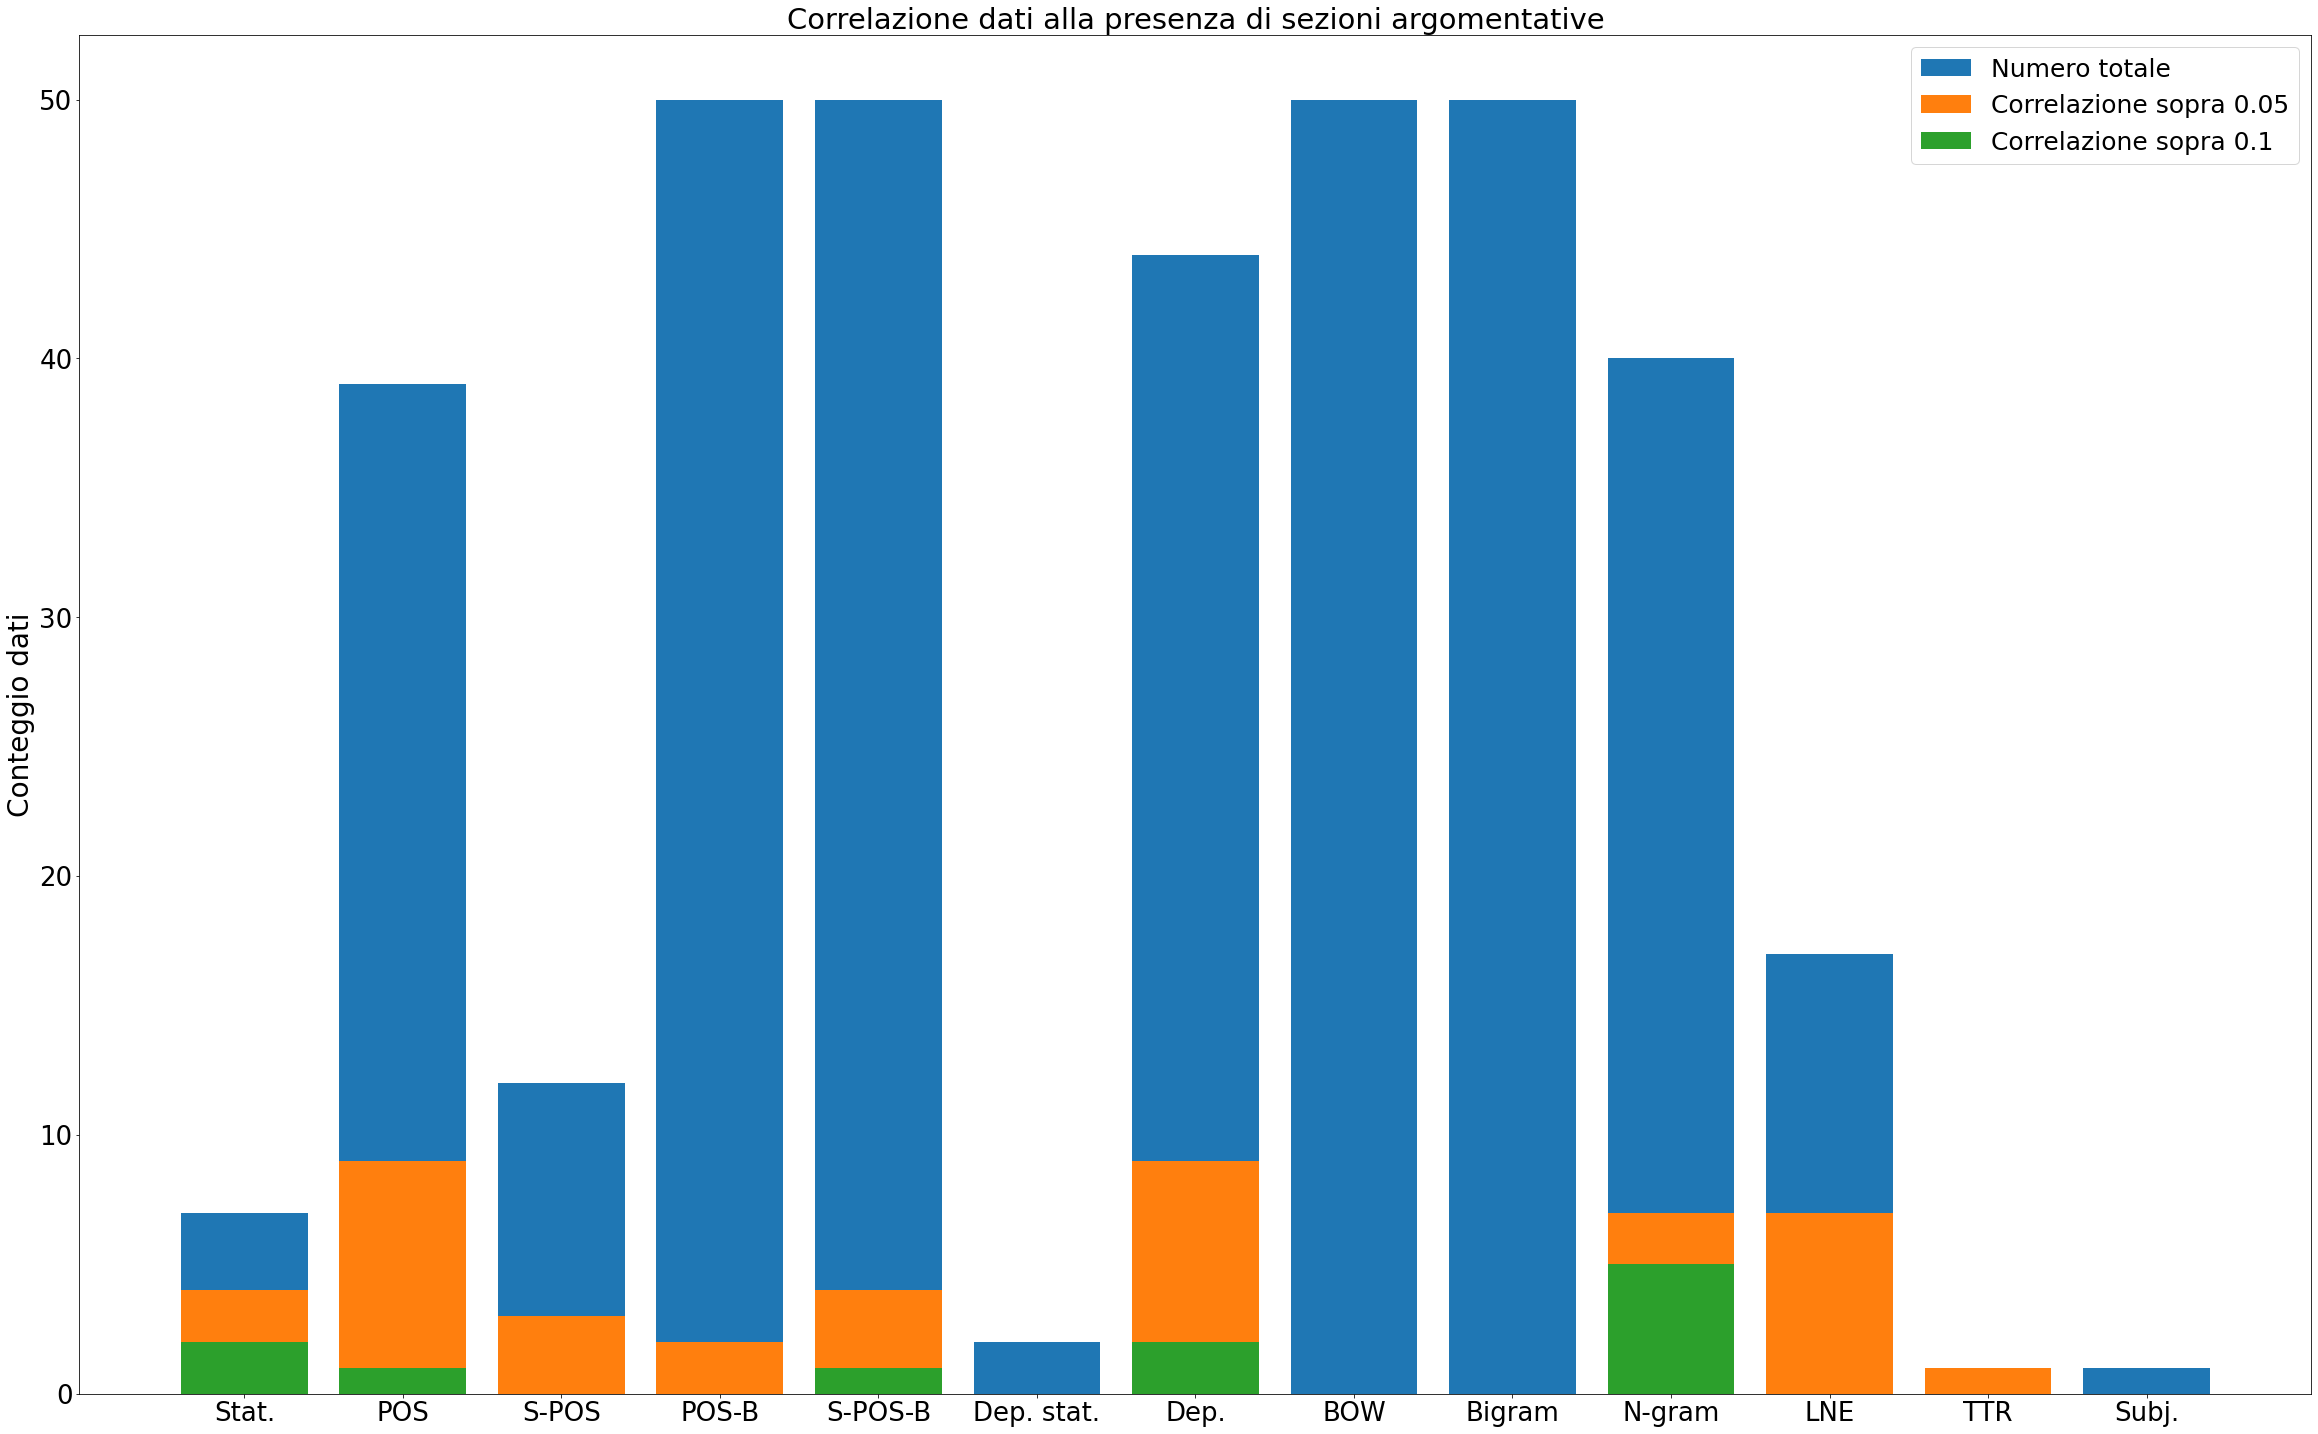

In [ ]:
# Obtain a visual representation of the type of data with the higher number of correlated 
# element to the argumentative sections and with the higher number of element in general.

fig, ax = plt.subplots(1, 1, figsize=(40, 25))
title='Correlazione dati alla presenza di sezioni argomentative'
count=[count_total,count_relevant_05,count_relevant_10]

    
ax.set_title('{}'.format(title), fontsize=29)
for i in range(3):
  ax.bar(data_group_names,count[i])
ax.legend(["Numero totale","Correlazione sopra 0.05","Correlazione sopra 0.1"],prop={'size': 25})
plt.ylabel('Conteggio dati', fontsize=28)
fig.show()